# Carrefour Hackathon I
**Goal:** Predicting the category of a product. There exists a main category that is then split into sublevels.
The level we'll focus on in this project is the third one.

*Authors:* Vanessa Chahawane, Ashraf Ghyie, Karim Siala, Mohamed Ali Jebali, Rania Ferchichi 

---

This is the very first step of our project. In this notebook we explore the data that we have.
In fact, given 180GB of images, we know we won't be able to use all of them for the training.
Here we focus on the **metadata** table to figure out which supset of these images to use, depending on the angles, skewness etc.

*NB: We provide a total of 3 notebooks; one for metadata exploration, one for creating a training set, and finally, one for the model and it's evaluation. Please refer to each notebook for the part you wish to see for this project.*

---

In [1]:
from google.cloud import bigquery, storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

## Exploring the full metadata table

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [3]:
bq_client = bigquery.Client(location="EU", project="hackathon-2021-305208")

In [4]:
# Retrieving the table of the metadata
# Here, we keep only the rows where the primary_link is true.

query = """
    SELECT *
    EXCEPT (arbonodes, location, is_primary_link, structHyp)
    FROM
     `hackathon-2021-305208.common_referential.metadata_images`,
      unnest(arbonodes) a,
      unnest(location) l
    WHERE a.is_primary_link='true'
"""
query_job = bq_client.query(
    query,
    location="EU",
)

In [6]:
df = query_job.to_dataframe()
print(df.shape)
df.head(3)

(118955, 15)


,barcode,item_desc,brand_name,nature,packaging,nodeid1,level1,nodeid2,level2,nodeid3,level3,nodeid4,level4,img_loc,img_angle
0,3307139936826,Romarin Bio JARDIN BIO,JARDIN BIO,romarin,le sachet de 40g,1882,Fruits et Légumes,1892,Légumes,28538,Herbes aromatiques et Epices,28541,Autres herbes aromatiques,gs://datacamp-images/images/image_330713993682...,1
1,3307139936826,Romarin Bio JARDIN BIO,JARDIN BIO,romarin,le sachet de 40g,1882,Fruits et Légumes,1892,Légumes,28538,Herbes aromatiques et Epices,28541,Autres herbes aromatiques,gs://datacamp-images/images/image_330713993682...,31
2,3307139936826,Romarin Bio JARDIN BIO,JARDIN BIO,romarin,le sachet de 40g,1882,Fruits et Légumes,1892,Légumes,28538,Herbes aromatiques et Epices,28541,Autres herbes aromatiques,gs://datacamp-images/images/image_330713993682...,34


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118955 entries, 0 to 118954
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   barcode     118955 non-null  object
 1   item_desc   118955 non-null  object
 2   brand_name  117991 non-null  object
 3   nature      116620 non-null  object
 4   packaging   118292 non-null  object
 5   nodeid1     118955 non-null  object
 6   level1      118955 non-null  object
 7   nodeid2     118955 non-null  object
 8   level2      118955 non-null  object
 9   nodeid3     117212 non-null  object
 10  level3      117212 non-null  object
 11  nodeid4     45404 non-null   object
 12  level4      45404 non-null   object
 13  img_loc     118955 non-null  object
 14  img_angle   118955 non-null  object
dtypes: object(15)
memory usage: 13.6+ MB


In [8]:
print('number of unique products: ', df['barcode'].nunique())

number of unique products:  21928


Aside from the null values, we also want to see if there are any **skewed or duplicated rows.**
For that we reconstruct the nested dataframe

In [10]:
# retrieving the nested dataset, supposedly per product
# serves to check for skewness
to_drop = ['img_loc', 'img_angle']
df_nested = df.drop(to_drop, axis=1).drop_duplicates()
print(df_nested.shape)


# Now we can check the products with multiple primary links
# skewed rows: multiple primary links
print('number of duplicated products: ', df_nested.duplicated(['barcode']).sum())
df_nested[df_nested.duplicated(['barcode'], keep=False)].head(6)

(21949, 13)
number of duplicated products:  21


,barcode,item_desc,brand_name,nature,packaging,nodeid1,level1,nodeid2,level2,nodeid3,level3,nodeid4,level4
5594,3424150033775,Vin rosé Coteaux d'Aix en Provence AOP Bio CHA...,REFS.SANS MARQUE,vin rosé,la bouteille de 75cL,1838,Bio et Ecologie,1865,Boissons,1869,"Vins, Cidres et Bières",None,None
5595,3424150033775,Vin rosé Coteaux d'Aix en Provence AOP Bio CHA...,REFS.SANS MARQUE,vin rosé,la bouteille de 75cL,27070,Boissons,27074,Cave à vins,27107,Vins rosés,28272,Provence
7109,3700654000018,Croquettes pour chiens volaille Bio NESTOR BIO,NESTOR BIO,croquette pour chien,le sac de 2Kg,1838,Bio et Ecologie,1881,Animaux,None,None,None,None
7113,3700654000018,Croquettes pour chiens volaille Bio NESTOR BIO,NESTOR BIO,croquette pour chien,le sac de 2Kg,29014,Animalerie,29016,Chiens,29057,Croquettes pour chiens,29134,Croquettes standards
9415,3560071253967,Sandwich jambon mozzarella CARREFOUR BON APPETIT,BON APPETIT URBAIN,sandwich,le sandwich de 160g,2041,Traiteur,2055,"Sandwichs, croques et galettes",2056,Sandwich et burger,None,None
9421,3560071253967,Sandwich jambon mozzarella CARREFOUR BON APPETIT,BON APPETIT URBAIN,sandwich,le sandwich de 160g,28127,Frais,28134,Snacking et Plats cuisinés,28350,Sandwichs,28354,Club sandwichs


Because of these rows, one product can **belong to 2 or more different categories**. so we won't be using them for our training.

In [22]:
# remove skewed rows, clean contains unique barcodes 
# with one primary links
null_counts = df_nested.isnull().sum(axis=1).to_frame(name='null_counts')

clean = df_nested.loc[
    df_nested.merge(
        null_counts,
        left_index=True,
        right_index=True
    ).groupby(by='barcode')['null_counts'].idxmin()
]
print('number of duplicated products: ', clean.duplicated(['barcode']).sum())
print(f'cleaned: {clean.shape} | skewed: {df_nested.shape}')

number of duplicated products:  0
cleaned: (21928, 13) | skewed: (21949, 13)


Now we can take a look at distributions of views, angles etc.

## Angles distribution

In [24]:
product_views = df.groupby(by=['barcode'], axis=0)['img_angle'].count()
product_views = pd.DataFrame(product_views)

product_views.columns = ['views_count']

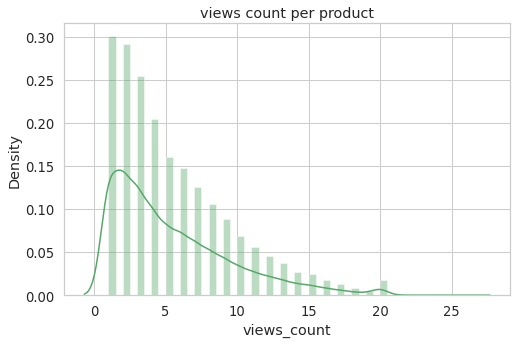

In [28]:
import warnings
warnings.simplefilter("ignore")
sns.set(style="whitegrid", font_scale=1.2)

figure = plt.figure(figsize=(8,5))
sns.distplot(product_views['views_count'], color='g');
plt.title('views count per product')
plt.show()

In [29]:
views_dist = df.groupby(by=['img_angle'], axis=0)['barcode'].count()
views_dist = pd.DataFrame(views_dist)
views_dist.columns = ['angle_count']

views_dist.index = views_dist.index.astype('int8')
views_dist.sort_index(inplace=True)

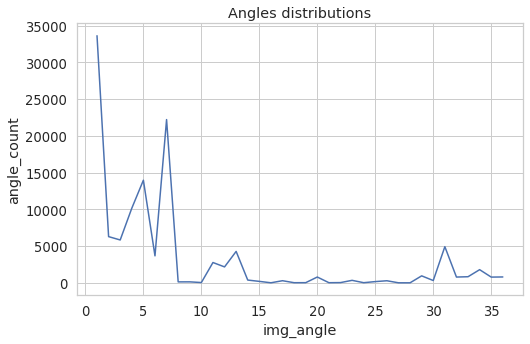

In [31]:
figure = plt.figure(figsize=(8,5))

sns.lineplot(x=views_dist.index, y=views_dist['angle_count']);
plt.title('Angles distributions')
plt.show()

We can notice that products have mostly front views. Remember that the front views angles have ids equal to **1, 11 or 31**. We may take this into consideration and use only the front angles for the training.

But enough of the views, let's now look at the labels.

## Exploring the levels

In [32]:
level_cols = ['barcode', 'level1', 'level2', 'level3', 'level4']
# levels = df[level_cols].drop_duplicates(['barcode'])

levels = clean[level_cols]
level_counts = levels.drop(['barcode'], axis=1).nunique()

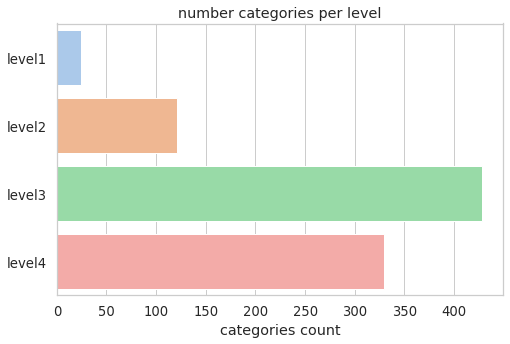

In [34]:
figure = plt.figure(figsize=(8,5))

sns.barplot(y=level_counts.index, x=level_counts.values, palette='pastel', orient='h');
plt.xlabel('categories count')
plt.title('number categories per level')
plt.show()

-------------------------------------------------Top 30 categories for each level-------------------------------------------------



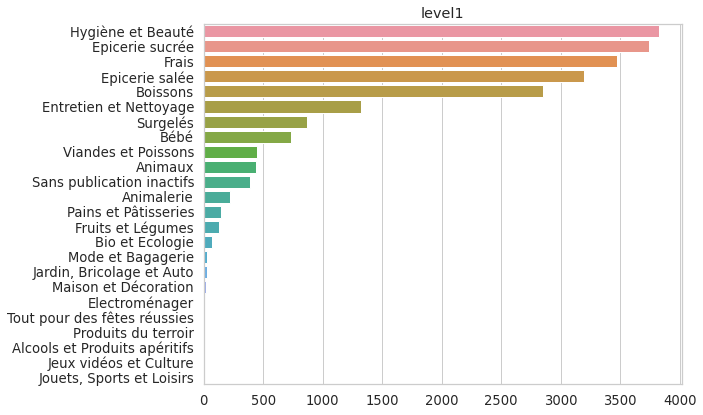

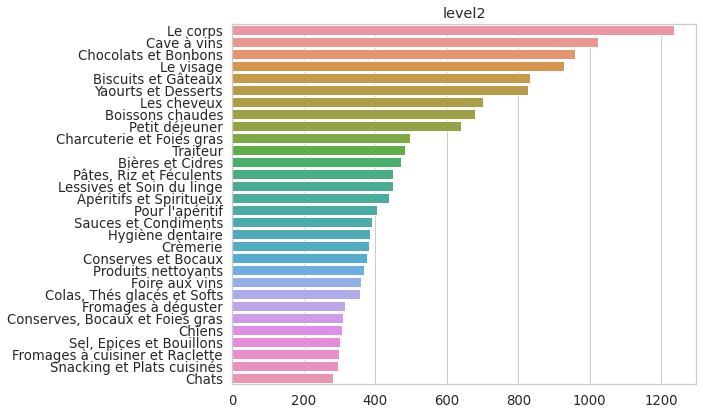

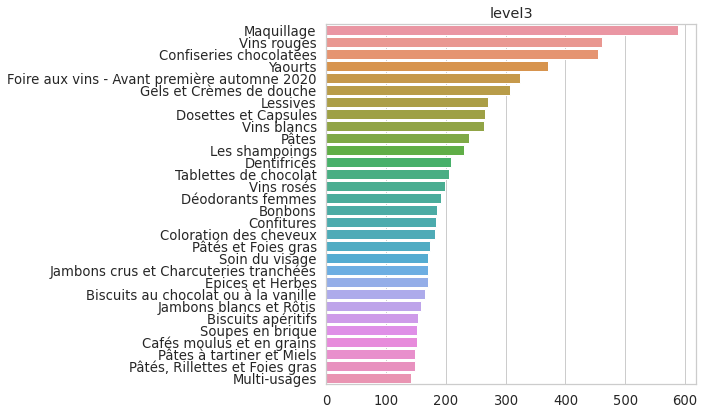

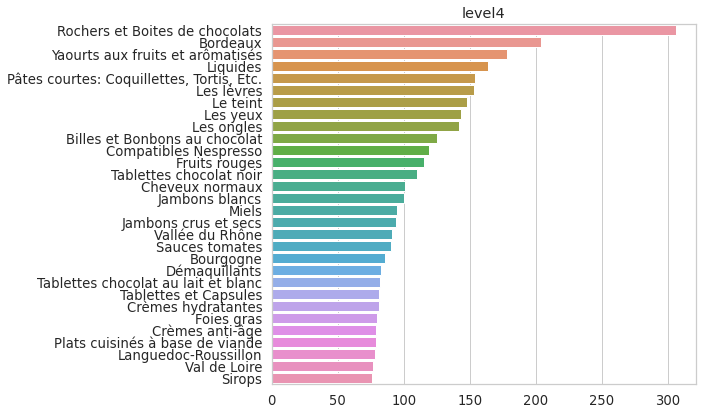

In [44]:
top = 30
print('Top {} categories for each level'.format(top).center(130, '-'))
print()
for level in level_counts.index:
    vc = levels[level].value_counts()[:top]
    fig = plt.figure(figsize=(10,6))
    sns.barplot(y=vc.index, x=vc.values, orient='h');
    plt.title(level)
    plt.tight_layout()
    plt.show()

The data is definitely imbalanced, with some classes not represented enough for the learning.

In [45]:
# builds mapping between the nodeid and the level
# we will need this later to decode our predicted classes

def build_id_map_from(level):
    grouped = clean[f'level{level}'].groupby(by=clean[f'nodeid{level}'])
    node_to_level = grouped.agg(['unique', 'nunique']).rename(columns={'unique': f'label_l{level}', 'nunique': 'count'})
    return pd.DataFrame(node_to_level).sort_values(['count'], ascending=False)

In [46]:
n3_l3 = build_id_map_from(3)
n3_l3

,label_l3,count
nodeid3,,
27117,"[Coffrets bières et Calendriers de l'avent , C...",2
2103,"[Bûches, Viennoiseries et Pâtisseries, Pains, ...",2
2450,"[Bains de bouche et Soins, Bains de bouche et ...",2
1847,[Fromages],1
27100,[Citronnades et Boissons bien-être],1
...,...,...
2251,[Compotes],1
2249,[Autres confiseries],1
2248,[Chewings gums],1


We have a total of **438** classes. However the table shows that some id's correspong to different levels. But since the count below shows that we actually have more nodeid's than classes, it means that some different id's reference the same class.

In [48]:
# But also, some or the same labels have different id's
print('number level3 catgories: ', clean['level3'].nunique())
print('number node ids in level3:', clean['nodeid3'].nunique())

number level3 catgories:  428
number node ids in level3: 438


Finally, we can examine the tree of all labels below.

In [50]:
!http_proxy=http://10.3.0.2:8080/ https_proxy=http://10.3.0.2:8080/ pip install treelib

  Created wheel for treelib: filename=treelib-1.6.1-py3-none-any.whl size=18371 sha256=71b85269e90cac241e2ab12716529f5361f4b4bfaa08094e341936e967dfa95d
  Stored in directory: /home/jupyter/.cache/pip/wheels/89/be/94/2c6d949ce599d1443426d83ba4dc93cd35c0f4638260930a53
Successfully built treelib


In [51]:
from treelib import Node, Tree
tree = Tree()

tree.create_node('root', 'root')

for i, r in clean.drop_duplicates('level1').dropna(how='all').iterrows():
    tree.create_node(r['level1'], r['level1'], parent='root')

def handle_level(tree, level):
    for i, r in clean.drop_duplicates(f'level{level}').dropna(how='all').iterrows():
        l = r[f'level{level}']
        parent = r[f'level{level-1}']
        #print(r['level3'])
        try:
            if l is not None:
                tree.create_node(l, l, parent=parent)
        except:
            pass

handle_level(tree, 2)
handle_level(tree, 3)
handle_level(tree, 4)

tree.show()

root
├── Alcools et Produits apéritifs
├── Animalerie
│   ├── Basse-cour
│   ├── Chats
│   │   ├── Boîtes et barquettes chats
│   │   ├── Colliers et Laisses pour chat
│   │   │   └── Colliers
│   │   ├── Croquettes chats
│   │   ├── Croquettes pour chats
│   │   │   └── Croquettes standards 
│   │   ├── Friandises et laits
│   │   ├── Gamelles et Accessoires repas
│   │   │   ├── Fontaines à eau
│   │   │   └── Gamelles
│   │   ├── Jouets, Griffoirs et Arbres à chat
│   │   │   ├── Arbres à chat
│   │   │   ├── Balles et Souris
│   │   │   ├── Griffoirs
│   │   │   └── Jouets d'éveil
│   │   ├── Laits et Friandises pour chats
│   │   ├── Litière et accessoires
│   │   ├── Litières et Hygiène
│   │   │   ├── Accessoires pour litière
│   │   │   ├── Antiparasitaire
│   │   │   ├── Bacs à litière
│   │   │   ├── Brosserie
│   │   │   ├── Litières agglomérantes
│   │   │   ├── Litières végétales
│   │   │   └── Soins pour chats
│   │   ├── Pâtées pour chats
│   │   │   ├── Boîtes et Barqu